In [ ]:
from numpy import mean, std, dstack, argmax, max
from pandas import read_csv
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.utils import to_categorical

In [ ]:
# drive path
drive = '/content/drive/My Drive/Colab Notebooks/HAR'

# local path
# local = 'G:/My Drive/Colab Notebooks/HAR'
local = 'G:/HAR'

hapt = '/HAPT Dataset'       # Human Activity Postural Transitions data set
har = '/UCI HAR Dataset'      # Human Activity Recognition data set

path_drive = drive + har
path_local = local + har

In [ ]:
using_drive = 1

if using_drive == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  path = path_drive
else:
  path = path_local

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gravitational acceleration data files for x, y and z axes: `total_acc_x_train.txt`, `total_acc_y_train.txt` , `total_acc_z_train.txt`.<br>
Body acceleration data files for x, y and z axes: `body_acc_x_train.txt`, `body_acc_y_train.txt`, `body_acc_z_train.txt`.<br>
Body gyroscope data files for x, y and z axes: `body_gyro_x_train.txt`,
`body_gyro_y_train.txt`, `body_gyro_z_train.txt`.<br>
The structure is mirrored in the test directory.

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
  dataframe = read_csv(filepath, header=None, delim_whitespace=True, encoding='utf-8', encoding_errors='ignore')
  return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
  loaded = list()
  for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
  # stack group so that features are the 3rd dimension
  loaded = dstack(loaded)
  return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
  filepath = prefix + '/' + group + '/Inertial Signals/'
  # load all 9 files as a single array
  filenames = list()
  # total acceleration
  filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
  # body acceleration
  filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
  # body gyroscope
  filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
  # load input data
  X = load_group(filenames, filepath)
  # load class output
  # y = load_file(prefix + '/' + group + '/y_' + group + '.txt') # doesn't work with default 'utf-8'
  y = read_csv(prefix + '/' + group + '/y_' + group + '.txt', header=None, encoding='utf-16')
  return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(path=''):
  # print(path)
  # load all train
  trainX, trainy = load_dataset_group('train', path)
  # load all test
  testX, testy = load_dataset_group('test', path)
  # zero-offset class values
  trainy = trainy - 1
  testy = testy - 1
  # one hot encode y
  trainy = to_categorical(trainy)
  testy = to_categorical(testy)
  return trainX, trainy, testX, testy

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 500, 32 # default 0, 10, 32
  n_timesteps, n_features, n_outputs = trainX.shape[1], int(trainX.shape[2]/3), trainy.shape[1]
  filter_size = 7 # default 3
  pool_size = 2 # default 2
  dropout = 0.25 # default 0.5
  num_of_filters = 128 # default 64
  # head 1
  inputs1 = Input(shape=(n_timesteps,n_features))
  conv1_1 = Conv1D(num_of_filters, filter_size, activation='relu')(inputs1)
  drop1_1 = Dropout(dropout)(conv1_1)
  pool1_1 = MaxPooling1D(pool_size=pool_size)(drop1_1)
  conv1_2 = Conv1D(32, filter_size, activation='relu')(pool1_1)
  drop1_2 = Dropout(0.5)(conv1_2)
  pool1_2 = MaxPooling1D()(drop1_2)
  flat1 = Flatten()(pool1_2)
  # head 2
  inputs2 = Input(shape=(n_timesteps,n_features))
  conv2_1 = Conv1D(num_of_filters, filter_size, activation='relu')(inputs2)
  drop2_1 = Dropout(dropout)(conv2_1)
  pool2_1 = MaxPooling1D(pool_size=pool_size)(drop2_1)
  conv2_2 = Conv1D(32, filter_size, activation='relu')(pool2_1)
  drop2_2 = Dropout(0.5)(conv2_2)
  pool2_2 = MaxPooling1D()(drop2_2)
  flat2 = Flatten()(pool2_2)
  # head 3
  inputs3 = Input(shape=(n_timesteps,n_features))
  conv3_1 = Conv1D(num_of_filters, filter_size, activation='relu')(inputs3)
  drop3_1 = Dropout(dropout)(conv3_1)
  pool3_1 = MaxPooling1D(pool_size=pool_size)(drop3_1)
  conv3_2 = Conv1D(32, filter_size, activation='relu')(pool3_1)
  drop3_2 = Dropout(0.5)(conv3_2)
  pool3_2 = MaxPooling1D()(drop3_2)
  flat3 = Flatten()(pool3_2)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(100, activation='relu')(merged) # default 100
  # dense2 = Dense(512, activation='relu')(dense1)
  # dense3 = Dense(256, activation='relu')(dense2)
  # dense4 = Dense(128, activation='relu')(dense3)
  # dense5 = Dense(64, activation='relu')(dense4)
  # outputs = Dense(n_outputs, activation='softmax')(dense5)
  outputs = Dense(n_outputs, activation='softmax')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  opt = keras.optimizers.Adam(learning_rate=0.001) # default 0.001
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  # when each head gets a different axis of samples
  x_indices = (0,3,6) # input for head1
  y_indices = (1,4,7) # input for head2
  z_indices = (2,5,8) # input for head3
  # when each head gets a different type of samples
  total_acc_indices = (0,1,2) # input for head1
  body_acc_indices = (3,4,5) # input for head2
  body_gyro_indices = (6,7,8) # input for head3
  # assign the indices
  # indices_1 = x_indices
  # indices_2 = y_indices
  # indices_3 = z_indices
  indices_1 = total_acc_indices
  indices_2 = body_acc_indices
  indices_3 = body_gyro_indices
  # fit network
  model.fit([trainX[:,:,indices_1], trainX[:,:,indices_2], trainX[:,:,indices_3]], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate([testX[:,:,indices_1], testX[:,:,indices_2], testX[:,:,indices_3]], testy, batch_size=batch_size, verbose=0)
  return accuracy, model, indices_1, indices_2, indices_3

In [ ]:
# summarize scores
def summarize_results(scores):
  print(scores)
  m, s = mean(scores), std(scores)
  print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
# run an experiment
def run_experiment(repeats=10, path=''):
  print("Experiment starting.")
  # load data
  trainX, trainy, testX, testy = load_dataset(path)
  print("Finished loading dataset, starting model training.")
  # repeat experiment
  scores = list()
  models = list()
  for r in range(repeats):
    score, model, indices_1, indices_2, indices_3 = evaluate_model(trainX, trainy, testX, testy)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
    models.append(model)
  # summarize results
  summarize_results(scores)
  return scores, models, testX, testy, indices_1, indices_2, indices_3

In [ ]:
# run the experiment and get the best model
scores, models, testX, testy, indices_1, indices_2, indices_3 = run_experiment(path=path)
best_model = models[argmax(scores)]
best_accuracy = max(scores)
print(best_model.summary())

Experiment starting.
Finished loading dataset, starting model training.
>#1: 94.503
>#2: 94.537
>#3: 94.197
>#4: 94.571
>#5: 94.401
>#6: 94.503
>#7: 93.858
>#8: 94.367
>#9: 95.555
>#10: 94.096
[94.50288414955139, 94.53681707382202, 94.19748783111572, 94.57074999809265, 94.4010853767395, 94.50288414955139, 93.85815858840942, 94.36715245246887, 95.55479884147644, 94.09568905830383]
Accuracy: 94.459% (+/-0.424)
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 128, 3)]             0         []                            
                                                                                                  
 input_56 (InputLayer)       [(None, 128, 3)]             0         []                            
                                                                           

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# convert labels back from one-hot encoded to label encoding
testy_label_encoded = np.argmax(testy, axis=1)

# predict the classes using the best model
y_pred = best_model.predict([testX[:,:,indices_1], testX[:,:,indices_2], testX[:,:,indices_3]])
y_pred_classes = np.argmax(y_pred, axis=1)

# compute the confusion matrix
conf_mat = confusion_matrix(testy_label_encoded, y_pred_classes)

93/93 [==============================] - 0s 3ms/step


<Figure size 1000x700 with 0 Axes>

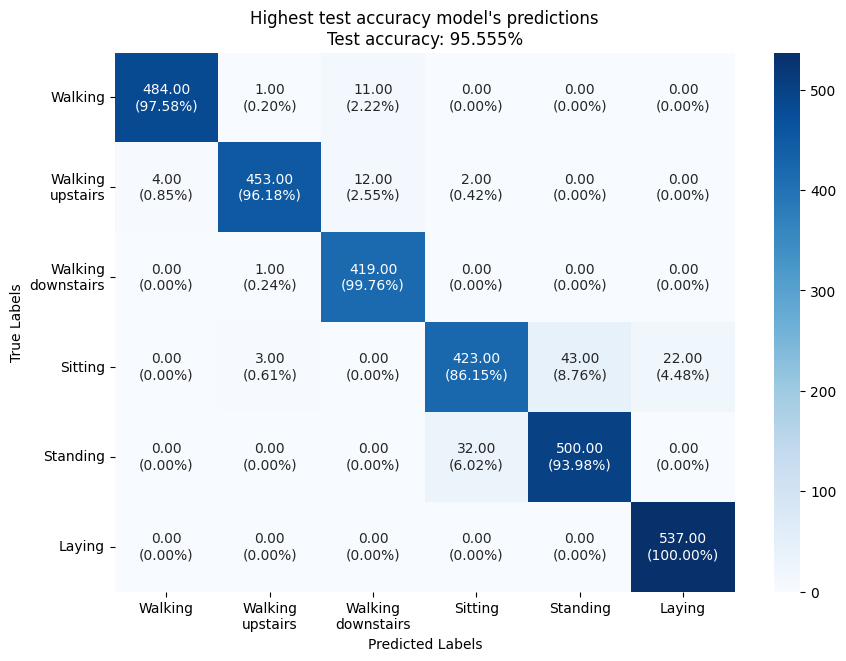

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

actions = {1:"Walking", 2:"Walking\nupstairs", 3:"Walking\ndownstairs", 4:"Sitting", 5:"Standing", 6:"Laying"}

plt.figure(figsize=(10,7))

# Calculate the percentage of success for each class
percentage_matrix = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Create a new matrix for the labels including the success percentages
percentage_labels = np.asarray([f"{val:.2f}\n({percentage:.2%})" for val, percentage in zip(conf_mat.flatten(), percentage_matrix.flatten())]).reshape(conf_mat.shape)

plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=percentage_labels, fmt='', cmap='Blues', xticklabels=actions.values(), yticklabels=actions.values())

plt.title(f"Highest test accuracy model's predictions\nTest accuracy: {round(best_accuracy, 3)}%")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()